### import

In [1]:
import os
import json
import logging
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import pandas as pd
import numpy as np
from IPython.display import Image, display

# Vector DB
import chromadb
from chromadb.utils import embedding_functions

# Embedding Models
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image as PILImage

# LLM
from vertexai.generative_models import GenerativeModel, Part, Image as VertexImage
import vertexai

# PDF處理
import PyPDF2

# 設置日誌
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 檢查並創建必要的目錄
Path('chroma_db').mkdir(exist_ok=True)
Path('image').mkdir(exist_ok=True)

/Users/zirong/miniforge3/envs/llm/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


### voice to text


In [ ]:
# whisper /Users/zirong/Desktop/test.mp4 --language Chinese --model tiny
import whisper
def transcribe_file(file_path, model_size="base"):
    model = whisper.load_model(model_size)
    result = model.transcribe(file_path)
    return result["text"]

# def main():
#     audio_file = "no_upload/test_mp3/01.mp3"  # 修改為你的音檔路徑
#     transcription = transcribe_file(audio_file)
#     print("Transcription:", transcription)

# if __name__ == "__main__":
#     main()

/Users/zirong/miniforge3/envs/llm/lib/python3.9/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location

Transcription: 我家的狗最近早上總是10歲晚上總是一直起來賺全權這樣是實質症狀嗎?


### 圖片處理

In [8]:
from typing import Union  # 添加 Union 导入

class ImageProcessor:
    def __init__(self, image_dir: str = "image"):
        self.image_dir = Path(image_dir)
        self.image_dir.mkdir(exist_ok=True)
        
    def process_and_save(
        self,
        image_path: Union[str, Path],  # 使用 Union 替代 |
        target_size: Tuple[int, int],
        prefix: str = "resized_",
        quality: int = 95
    ) -> Optional[Path]:
        """统一的图片处理方法，处理并保存图片"""
        try:
            # 确保 image_path 是 Path 对象
            image_path = Path(image_path)
            if not str(image_path).startswith(str(self.image_dir)):
                image_path = self.image_dir / image_path
                
            # 检查图片是否存在
            if not image_path.exists():
                logger.error(f"Image not found: {image_path}")
                return None
                
            # 读取并处理图片
            image = PILImage.open(image_path)
            
            # 转换为 RGB 模式
            if image.mode != 'RGB':
                image = image.convert('RGB')
                
            # 计算等比例缩放的大小
            width, height = image.size
            ratio = min(target_size[0]/width, target_size[1]/height)
            new_size = (int(width * ratio), int(height * ratio))
            
            # 缩放图片
            image = image.resize(new_size, PILImage.Resampling.LANCZOS)
            
            # 创建新的白色背景图片
            new_image = PILImage.new('RGB', target_size, (255, 255, 255))
            
            # 计算居中位置
            x = (target_size[0] - new_size[0]) // 2
            y = (target_size[1] - new_size[1]) // 2
            
            # 贴上缩放后的图片
            new_image.paste(image, (x, y))
            
            # 生成输出路径
            output_path = self.image_dir / f"{image_path.name}" #output_path = self.image_dir / f"{prefix}{image_path.name}"
            # 保存处理后的图片
            new_image.save(output_path, quality=quality)
            logger.info(f"Saved processed image to: {output_path}")
            
            return output_path
            
        except Exception as e:
            logger.error(f"Error processing image {image_path}: {str(e)}")
            return None
            
    def load_for_display(self, 
                        image_path: Union[str, Path],  # 使用 Union 替代 |
                        display_size: Tuple[int, int]) -> Optional[PILImage.Image]:
        """载入图片用于显示"""
        try:
            processed_path = self.process_and_save(image_path, display_size, prefix="display_")
            if processed_path:
                return PILImage.open(processed_path)
            return None
        except Exception as e:
            logger.error(f"Error loading image for display {image_path}: {str(e)}")
            return None

### Embedding 處理模組

In [9]:
%matplotlib inline
# from IPython.display import display, Image
class HybridEmbeddingProcessor:
    # 初始化 embedding processor
    def __init__(self, 
                persist_directory: str = "chroma_db",
                image_dir: str = "image",
                image_size: tuple = (224, 224)):
        self.image_dir = Path(image_dir)
        self.image_size = image_size
        self.image_processor = ImageProcessor(image_dir)
        
        # 初始化模型
        self.text_model = SentenceTransformer('all-mpnet-base-v2')
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # 設置 Chroma，使用已下載的 SentenceTransformer
        logger.info(f"Initializing Chroma with directory: {persist_directory}")
        self.chroma_client = chromadb.PersistentClient(path=persist_directory)
        
        # 創建或獲取集合，使用 SentenceTransformer embedding function
        sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
            model_name='all-mpnet-base-v2',
            device="cpu"  # 明確指定設備
        )
        
        try:
            # 先嘗試刪除現有的集合（如果存在）
            try:
                self.chroma_client.delete_collection("text_documents")
                self.chroma_client.delete_collection("image_documents")
                logger.info("Deleted existing collections")
            except:
                logger.info("No existing collections to delete")
            
            # 創建新的集合
            self.text_collection = self.chroma_client.create_collection(
                name="text_documents",
                embedding_function=sentence_transformer_ef
            )
            
            self.image_collection = self.chroma_client.create_collection(
                name="image_documents"
            )
            logger.info("Created new collections")
            
        except Exception as e:
            logger.error(f"Error initializing collections: {str(e)}")
            raise
        
        logger.info("Initialized hybrid embedding system")

    def process_image(self, image_path: str) -> Optional[np.ndarray]:
            """處理圖片並生成 embedding"""
            try:
                logger.info(f"Processing image: {image_path}")
                processed_path = self.image_processor.process_and_save(
                    image_path=image_path,
                    target_size=self.image_size
                )
                
                if processed_path is None:
                    logger.error(f"Failed to process image: {image_path}")
                    return None
                    
                image = PILImage.open(processed_path)
                inputs = self.clip_processor(images=image, return_tensors="pt")
                image_features = self.clip_model.get_image_features(**inputs)
                
                logger.info(f"Successfully generated embedding for image: {image_path}")
                return image_features.detach().numpy()[0]
                
            except Exception as e:
                logger.error(f"Error processing image {image_path}: {str(e)}")
                return None

    def add_documents(self, 
                     texts: List[str], 
                     metadatas: List[Dict],
                     images: Optional[List[str]] = None):
        """添加文件到不同的集合"""
        try:
            # 添加文本文件
            if texts and metadatas:
                logger.info(f"Adding {len(texts)} text documents")
                self.text_collection.add(
                    documents=texts,
                    metadatas=metadatas,
                    ids=[f"text_{i}" for i in range(len(texts))]
                )
                logger.info("Successfully added text documents")
            
            # 處理並添加圖片
            if images:
                logger.info(f"Processing {len(images)} images")
                image_embeddings = []
                valid_images = []
                valid_metadatas = []
                
                for i, img_path in enumerate(images):
                    logger.info(f"Processing image {i+1}/{len(images)}: {img_path}")
                    embedding = self.process_image(str(self.image_dir / img_path))
                    if embedding is not None:
                        image_embeddings.append(embedding.tolist())
                        valid_images.append(img_path)
                        valid_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_text": texts[i] if i < len(texts) else ""
                        })
                
                if valid_images:
                    logger.info(f"Adding {len(valid_images)} valid images to collection")
                    self.image_collection.add(
                        embeddings=image_embeddings,
                        metadatas=valid_metadatas,
                        ids=[f"img_{i}" for i in range(len(valid_images))]
                    )
                    logger.info("Successfully added images to collection")
                else:
                    logger.warning("No valid images to add to collection")
        
        except Exception as e:
            logger.error(f"Error adding documents: {str(e)}", exc_info=True)
            raise
    
    def process_text(self, text: str) -> np.ndarray:
        """使用 SentenceTransformer 處理文本"""
        try:
            embedding = self.text_model.encode(text)
            return embedding
        except Exception as e:
            logger.error(f"Error processing text: {str(e)}")
            return None
        
    def search(self, query: str, k: int = 3) -> Dict:
        """改進的搜索方法"""
        try:
            logger.info("Starting search operation...")
            
            # 檢查集合是否存在
            if not self.text_collection or not self.image_collection:
                logger.error("Collections not initialized properly")
                return {
                    "texts": {"documents": [[]], "metadatas": [[]], "distances": []},
                    "images": {"metadatas": [[]], "documents": [], "distances": []}
                }

            # 文本搜索
            text_results = self.text_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            # 圖片搜索
            try:
                inputs = self.clip_processor(
                    text=[query], 
                    return_tensors="pt", 
                    padding=True,
                    truncation=True,
                    max_length=77
                )
                text_features = self.clip_model.get_text_features(**inputs)
                query_embedding = text_features.detach().numpy()[0]
                query_embedding = query_embedding / np.linalg.norm(query_embedding)
                
                image_results = self.image_collection.query(
                    query_embeddings=[query_embedding.tolist()],
                    n_results=k
                )
                logger.info(f"Found {len(image_results['metadatas'][0]) if image_results['metadatas'] else 0} images")
                
            except Exception as e:
                logger.error(f"Error in image search: {str(e)}")
                image_results = {
                    "ids": [], 
                    "documents": [], 
                    "metadatas": [[]], 
                    "distances": []
                }
            
            return {
                "texts": text_results,
                "images": image_results
            }
            
        except Exception as e:
            logger.error(f"Search error: {str(e)}")
            return {
                "texts": {"documents": [[]], "metadatas": [[]], "distances": []},
                "images": {"metadatas": [[]], "documents": [], "distances": []}
            }

    def display_search_results(self, query: str, k: int = 3, display_size: tuple = (400, 400)):
        """顯示搜索結果"""
        results = self.search(query, k)
        
        print(f"Query: {query}\n")
        
        # 顯示圖片結果
        if results["image_relevance"] >= 0.3 and results["images"]["metadatas"]:
            print("Related Images:")
            try:
                for i, meta in enumerate(results["images"]["metadatas"][0], 1):
                    print(f"\nImage {i}:")
                    
                    # 使用統一的圖片處理方法載入圖片
                    img = self.image_processor.load_for_display(
                        image_path=meta['path'],
                        display_size=display_size
                    )
                    
                    if img is not None:
                        # 顯示圖片
                        display.display(display.Image(data=img.tobytes()))
                        
                        if 'associated_text' in meta:
                            print(f"Context: {meta['associated_text'][:200]}...")
                            
            except Exception as e:
                logger.error(f"Error displaying images: {str(e)}")
                print("Error displaying images")
        else:
            if results["image_relevance"] < 0.3:
                print("No images needed for this query")
            else:
                print("No relevant images found")

### 資料處理模組

In [10]:
class DataProcessor:
    def __init__(self, embedding_processor: HybridEmbeddingProcessor):
        self.embedding_processor = embedding_processor
        
    def process_csv_with_images(self, csv_path: str) -> Tuple[List[str], List[Dict], List[str]]:
        """處理 CSV 並提取圖片，確保 metadata 值都是基本類型"""
        logger.info(f"Processing CSV: {csv_path}")
        texts = []
        metadatas = []
        images = []
        
        df = pd.read_csv(csv_path)
        current_post = None
        current_responses = []
        current_images = []
        current_metadata = None
        
        for _, row in df.iterrows():
            # 開始新的貼文
            if pd.notna(row['post']):
                if current_post is not None:
                    # 保存前一個貼文
                    text = f"{current_post} {' '.join(current_responses)}"
                    texts.append(text)
                    if current_images:
                        current_metadata["images"] = ",".join(current_images)
                        images.extend(current_images)
                    # 將回應列表轉換為字符串，使用 | 作為分隔符
                    current_metadata["responses"] = "|".join(current_responses)
                    metadatas.append(current_metadata)
                
                # 初始化新貼文
                current_post = row['post']
                current_responses = []
                current_images = []
                current_metadata = {
                    "type": "social_post",
                    "source": "facebook",
                    "is_post": True,
                    "original_post": current_post
                }
                
                # 添加連結（如果有）
                if pd.notna(row['link']):
                    current_metadata["link"] = row['link']
            
            # 添加回覆
            if pd.notna(row['responses']):
                current_responses.append(row['responses'])
                
            # 處理圖片
            if pd.notna(row.get('images')):
                img_path = row['images']
                current_images.append(img_path)
                logger.info(f"Found image: {img_path} for current post")
        
        # 保存最後一個貼文
        if current_post is not None:
            text = f"{current_post} {' '.join(current_responses)}"
            texts.append(text)
            if current_images:
                current_metadata["images"] = ",".join(current_images)
                images.extend(current_images)
            # 將回應列表轉換為字符串
            current_metadata["responses"] = "|".join(current_responses)
            metadatas.append(current_metadata)
        
        # 顯示處理結果的詳細資訊
        for i, (text, meta) in enumerate(zip(texts, metadatas)):
            logger.info(f"\nPost {i+1}:")
            logger.info(f"Content: {text[:100]}...")
            logger.info(f"Images: {meta.get('images', 'No images')}")
            # 使用 split('|') 代替 split('\n')
            logger.info(f"Responses: {len(meta.get('responses', '').split('|'))} replies")
            logger.info(f"Link: {meta.get('link', 'No link')}")
        
        return texts, metadatas, images

    def process_pdf(self, pdf_path: str) -> List[Dict]:
        """處理 PDF 文件，確保 metadata 值都是基本類型"""
        logger.info(f"Processing PDF: {pdf_path}")
        documents = []
        
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                for page_num, page in enumerate(pdf_reader.pages):
                    text = page.extract_text()
                    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
                    
                    for para in paragraphs:
                        documents.append({
                            'content': para,
                            'metadata': {
                                'source': pdf_path,
                                'page': str(page_num + 1),  # 轉換為字符串
                                'type': 'pdf',
                                'content_length': str(len(para))  # 添加額外信息，也確保是字符串
                            }
                        })
            
            logger.info(f"Extracted {len(documents)} paragraphs from PDF")
            return documents
        except Exception as e:
            logger.error(f"Error processing PDF {pdf_path}: {str(e)}")
            return []

    def process_all(self, csv_path: str, pdf_path: str):
        """處理所有資料，確保所有 metadata 正確"""
        logger.info("Starting to process all documents...")
        
        try:
            # 處理 CSV 和圖片
            texts, metadatas, images = self.process_csv_with_images(csv_path)
            logger.info(f"\nFound {len(images)} images:")
            for img in images:
                logger.info(f"- {img}")
            
            # 檢查圖片文件是否存在
            image_dir = Path("image")
            valid_images = []
            for img in images:
                img_path = image_dir / img
                if img_path.exists():
                    logger.info(f"Image file exists: {img_path}")
                    valid_images.append(img)
                else:
                    logger.error(f"Image file not found: {img_path}")
            
            # 處理 PDF
            pdf_docs = self.process_pdf(pdf_path)
            texts.extend([doc['content'] for doc in pdf_docs])
            metadatas.extend([doc['metadata'] for doc in pdf_docs])
            
            logger.info(f"\nProcessing summary:")
            logger.info(f"- Total texts: {len(texts)}")
            logger.info(f"- Total valid images: {len(valid_images)}")
            
            # 最終檢查確保所有 metadata 值都是基本類型
            for meta in metadatas:
                for key, value in list(meta.items()):
                    if isinstance(value, (list, dict)):
                        meta[key] = str(value)
            
            # 添加到 Chroma
            self.embedding_processor.add_documents(
                texts=texts,
                metadatas=metadatas,
                images=valid_images
            )
            
            logger.info(f"Successfully processed all documents")
            return len(texts), len(valid_images)
            
        except Exception as e:
            logger.error(f"Error processing documents: {str(e)}")
            raise

### QA系統模組

In [5]:
role = """
You are a professional veterinarian specializing in:

Diagnosis and care of Canine Cognitive Dysfunction Syndrome (CCD)
Pet behavior problem diagnosis and improvement suggestions
"""

In [6]:
task = """
Please handle user questions according to the following steps:
Please refer to the references provided below to answer
Step 1: Determine if images are needed in the system response
Based on the question content:

Environment-related: Space planning, facility placement, equipment usage, etc.
Behavior-related: Posture, movement, physical appearance, etc.
Care-related: Wheelchairs, activity areas, equipment usage, etc.
Product recommendations: Medications, assistive devices

Step 2: Provide recommendations
Text response:

Provide professional advice based on textual information
Explain relevant symptoms and precautions
If there are relevant images, naturally incorporate image descriptions into the content
For example:
"Consider using MCT oil (as shown in Figure 1) for nutritional supplementation"
"Veterinarians may prescribe cognitive support medications (such as CogniCaps shown in Figure 2)"

If images are needed:

Find appropriate photos from reference materials
Naturally embed image descriptions within relevant recommendations rather than placing them all at the end
Explain how the images relate to the recommendations (e.g., this is the recommended nutritional supplement, this is a commonly prescribed medication, etc.)
If images are needed but not available in reference materials, proceed without images

Step 3: Response format

Symptom/problem analysis
Professional advice explanation
Recommendations based on community-collected data
Necessary medical reminders
If reference materials are used, mark the source at the end of the response, e.g., [xxx.pdf] or [Link] for community post references

Please respond with empathy and a professional tone.
"""

In [11]:
class QASystem:
    def __init__(self,
                 embedding_processor: HybridEmbeddingProcessor,
                 project_id: str,
                 location: str = "us-central1"):
        self.embedding_processor = embedding_processor
        self.init_llm(project_id, location)
        
    def init_llm(self, project_id: str, location: str):
        """初始化 Gemini"""
        vertexai.init(project=project_id, location=location)
        self.llm = GenerativeModel('gemini-1.0-pro-vision-001')
    
    def generate_response(self, query: str) -> Tuple[str, List[VertexImage]]:
        """改進的回應生成"""
        try:
            # 搜索相關內容
            search_results = self.embedding_processor.search(query)
            
            # 構建提示詞
            prompt = f"""
            {role}
            {task}
            references：{self.format_context(search_results)}
            User Questions：{query}
            """
            if search_results["images"]["metadatas"] and search_results["images"]["metadatas"][0]:
                prompt += "\n系統已提供相關圖片供參考。請分析圖片並提供建議。"
            else:
                prompt += "\n系統未提供相關圖片。請根據文字資料提供建議。"

            # 準備內容
            contents = [prompt]
            vertex_images = []
            
            # 添加圖片
            if search_results["images"]["metadatas"] and search_results["images"]["metadatas"][0]:
                logger.info(f"Found {len(search_results['images']['metadatas'][0])} relevant images")
                for metadata in search_results["images"]["metadatas"][0]:
                    img_path = self.embedding_processor.image_dir / metadata["path"]
                    if img_path.exists():
                        try:
                            image = VertexImage.load_from_file(str(img_path))
                            contents.append(image)
                            vertex_images.append(image)
                            logger.info(f"Successfully added image: {img_path}")
                        except Exception as img_error:
                            logger.error(f"Error processing image {img_path}: {str(img_error)}")
            
            # 生成回應
            logger.info(f"Generating response with {len(contents)} contents")
            response = self.llm.generate_content(contents)
            return response.text, vertex_images
                
        except Exception as e:
            logger.error(f"Error generating response: {str(e)}", exc_info=True)
            return f"抱歉，系統處理您的問題時發生錯誤: {str(e)}。請稍後再試。", []

    def format_context(self, search_results: Dict) -> str:
        """改進的上下文格式化，加強錯誤處理"""
        try:
            context = ""
            
            # 添加文本結果
            if (search_results["texts"]["documents"] and 
                search_results["texts"]["documents"][0] and 
                search_results["texts"]["metadatas"] and 
                search_results["texts"]["metadatas"][0]):
                
                for doc, meta in zip(
                    search_results["texts"]["documents"][0],
                    search_results["texts"]["metadatas"][0]
                ):
                    if meta["type"] == "pdf":
                        context += f"【醫學文獻】\n{doc}\n\n"
                    else:
                        context += f"【社群討論】\n{doc}\n"
                        if meta.get("link"):
                            context += f"來源：{meta['link']}\n\n"
            
            # 只在相關時添加圖片資訊
            if (search_results.get("image_relevance", 0) >= 0.3 and 
                search_results["images"].get("metadatas") and 
                search_results["images"]["metadatas"][0]):
                
                context += "\n【相關圖片】\n"
                for meta in search_results["images"]["metadatas"][0]:
                    context += f"- {meta['path']}\n"
            
            return context
            
        except Exception as e:
            logger.error(f"Error formatting context: {str(e)}")
            return "無法取得參考資料"

    def display_response(self, query: str):
        """顯示回應"""
        try:
            logger.info("Starting to generate response...")
            response_text, images = self.generate_response(query)
            
            print("問題：", query)
            print("\n系統的回答：")
            print(response_text)
            print("\n" + "-"*50 + "\n")

            logger.info(f"Response generated. Number of images: {len(images)}")
            if images:
                print("\n相關圖片：")
                for i, img in enumerate(images, 1):
                    logger.info(f"Displaying image {i}")
                    try:
                        display(img)
                    except Exception as e:
                        logger.error(f"Error displaying image {i}: {str(e)}")
            else:
                logger.info("No images to display")
                
        except Exception as e:
            logger.error(f"Error in display_response: {str(e)}", exc_info=True)


### 系統初始化和資料處理

In [12]:
# 初始化 embedding processor
embedding_processor = HybridEmbeddingProcessor(
    image_size=(224, 224)  # 設定圖片處理的目標尺寸
)

# 初始化數據處理器
data_processor = DataProcessor(embedding_processor)

# 處理資料
num_texts, num_images = data_processor.process_all(
    csv_path="post_response.csv",
    pdf_path="salvin2010.pdf"
)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:__main__:Initializing Chroma with directory: chroma_db
INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:__main__:Deleted existing collections
INFO:__main__:Created new collections
INFO:__main__:Initialized hybrid embedding system
INFO:__main__:Starting to process all documents...
INFO:__main__:Processing CSV: post_response.csv
INFO:__main__:Found image: image01.jpg for current post
INFO:__main__:Found image: image02.jpg for current post
INFO:__main__:Found image: image03.jpg for current post
INFO:__main__:Found image: image04.jpg for current post
INFO:__main__:Found image: image05.jpg for current po

### 系統測試

In [13]:
# 初始化 QA 系統
qa_system = QASystem(
    embedding_processor=embedding_processor,
    project_id="high-tribute-438514-j7",  
    location="us-central1"
)

#### 用語音轉文字做輸入

/Users/zirong/miniforge3/envs/llm/lib/python3.9/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location

問題： 我家的狗最近早上總是10歲晚上總是一直起來賺全權這樣是實質症狀嗎?

系統的回答：
 您好，根據您的描述，您的狗狗可能有患上犬類認知功能障礙症候群（CCD）。CCD是一種常見於老年犬的疾病，其症狀包括：

* 晝夜顛倒
* 焦慮不安
* 吠叫不止
* 走動不停
* 大小便失禁
* 認知功能下降

如果您懷疑您的狗狗患有CCD，請盡快帶牠去看獸醫。獸醫會根據狗狗的症狀和體徵做出診斷，並開出適當的治療方案。

CCD的治療方法包括：

* 藥物治療
* 行為訓練
* 環境調整

在日常生活中，您可以做一些事情來幫助您的狗狗應對CCD，包括：

* 確保狗狗有足夠的睡眠時間
* 在狗狗熟悉的環境中活動
* 避免讓狗狗感到焦慮或不安
* 每天給狗狗適量的運動
* 定期帶狗狗去看獸醫

希望這些建議能幫助到您和您的狗狗。

--------------------------------------------------


相關圖片：


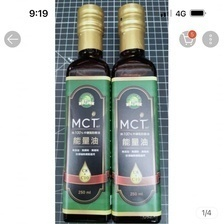

INFO:__main__:Displaying image 2


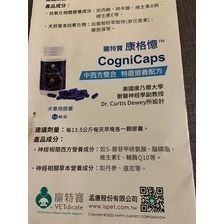

INFO:__main__:Displaying image 3


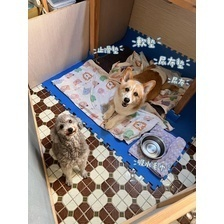

In [16]:
audio_file = "no_upload/test_mp3/01.mp3"  # 修改為你的音檔路徑
transcription = transcribe_file(audio_file)
qa_system.display_response(transcription)

#### 一般輸入

In [ ]:
# 測試查詢
test_queries = [
    "我家狗晚上會繞圈圈，不知道是不是算失智症狀？我想提前準備好，有適合她活動的佈置嗎？"
    # "給我關於活動佈置可以參考的圖"
    # 'My dog ​​walks in circles at night. Is this a symptom of dementia? I want to prepare in advance. Is there a suitable layout for her event?'
    # "老狗失智症有什麼症狀？",
    # "晚上狗狗一直叫該怎麼辦？"
]

for query in test_queries:
    qa_system.display_response(query)


### 互動式查詢介面

In [ ]:
from IPython.display import clear_output

def interactive_query():
    while True:
        query = input("請輸入您的問題 (輸入'quit'結束): ").strip()
        
        if query.lower() == 'quit':
            break
            
        clear_output(wait=True)
        qa_system.display_response(query)
        print("\n輸入新的問題或輸入'quit'結束")

# 啟動互動式查詢
interactive_query()